# Movie Recommendation System - *Content Based Filtering & Collaborative Filtering*

## Data Understanding

### Menyiapkan Library

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Menyiapakn Dataset

- Instalasi Paket Kaggle menggunakan perintah `!pip install kaggle`. Perintah ini akan mengunduh dan menginstal paket Kaggle dari Python Package Index (PyPI).

In [ ]:
!pip install kaggle

- Mengunggah token Kaggle API ke sesi Colab untuk mengakses dataset dan sumber daya Kaggle melalui Google Colab.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"waklenggazy","key":"6fa256fd2509d004df5a835de967beb5"}'}

- Konfigurasi Kaggle API

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

- Mengunduh dataset dari Kaggle

In [ ]:
!kaggle datasets download -d nicoletacilibiu/movies-and-ratings-for-recommendation-system

  0% 0.00/846k [00:00<?, ?B/s]
100% 846k/846k [00:00<00:00, 42.2MB/s]


- Melakukan Ekstraksi File zip

In [ ]:
local_zip = '/content/movies-and-ratings-for-recommendation-system.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

- Membaca File & Menampilkan Jumlah Data Unik

In [ ]:
movies = pd.read_csv('/content/movies.csv')
ratings = pd.read_csv('/content/ratings.csv')

print('Jumlah data movies: ', len(movies['movieId'].unique()))
print('Jumlah data ratings: ', len(ratings['movieId'].unique()))

Jumlah data movies:  9742
Jumlah data ratings:  9724


### Univariate Exploratory Data Analysis

#### Eksplorasi Variabel

- Eksplorasi Variabel menggunakan fungsi `movies.info()` pada Variabel Movies.

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


- Eksplorasi Variabel menggunakan fungsi `ratings.info()` pada Variabel Ratings.

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- Menampilkan Data Movies menggunakan fungsi `movies.head()`.

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


- Menampilkan Data Ratings menggunakan fungsi `ratings.head()`.

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


- Mendeskripsikan fitur ratings menggunakan fungsi `ratings.describe()`.

In [ ]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


- Mencetak Jumlah Data Ratings menggunakan Fungsi `len()`.

In [ ]:
print('Jumlah userID: ', len(ratings.userId.unique()))
print('Jumlah movieId: ', len(ratings.movieId.unique()))
print('Jumlah data rating: ', len(ratings))

Jumlah userID:  610
Jumlah movieId:  9724
Jumlah data rating:  100836


## Data Preparation

- Menambahkan Kolom `year_of_release` pada Data Movies

In [ ]:
movies['year_of_release'] = movies.title.str.extract('([0-9]{4})')
movies.head()

,movieId,title,genres,year_of_release
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


- Memisahkan Judul Film dari Tahun Rilis Menggunakan metode `split()`.

In [ ]:
movies['title'] = movies['title'].astype(str)
movies['title'] = movies['title'].str.split(pat='(', n=1).str[0].str.strip()
movies.head()

,movieId,title,genres,year_of_release
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


- Memeriksa Nilai pada kolom rating

In [ ]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

Rupanya, kolom ratings menunjukkan sebaran data yang tidak normal, di mana data rating memiliki skala 0.5 sampai 5 dengan perbedaan 0.5 pada setiap skala. Untuk konsistensi, akan dilakukan pembulatan sehingga rating memiliki rentang 1 hingga 5.

- Membulatkan nilai pada kolom 'rating' dengan menggunakan fungsi `np.ceil`.

In [ ]:
ratings['rating'] = ratings['rating'].apply(np.ceil)

- Periksa Kembali Nilai di kolom 'rating' menggunakan fungsi `ratings.rating.unique()`.

In [ ]:
ratings.rating.unique()

array([4., 5., 3., 2., 1.])

- Mengubah format waktu pada kolom 'timestamp' dengan menggunakan fungsi `pd.to_datetime`.

In [ ]:
ratings.timestamp = pd.to_datetime(ratings['timestamp'], unit='s')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


Sementara ini, frame data rating pengguna tampaknya sudah cukup baik.

- Menggabungkan Data Movies dan Ratings berdasarkan 'movieId' menggunakan fungsi `merge()`.

In [ ]:
df = pd.merge(movies, ratings, on='movieId', how='left')
df

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5.0,4.0,1996-11-08 06:36:02
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7.0,5.0,2005-01-25 06:52:26
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15.0,3.0,2017-11-13 12:59:30
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17.0,5.0,2011-05-18 05:28:03
...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:44:42
100850,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:52:25
100851,193585,Flint,Drama,2017,184.0,4.0,2018-09-16 14:56:45
100852,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,184.0,4.0,2018-09-16 15:00:21


- Mendeteksi `missing value` dengan fungsi isnull()

In [ ]:
df.isnull().sum()

movieId             0
title               0
genres              0
year_of_release    17
userId             18
rating             18
timestamp          18
dtype: int64

terdapat missing value pada kolom `year_of_release`, `userId`, `rating`, dan `timestamp`.

- Menghapus `missing value` dengan fungsi dropna()

In [ ]:
df_clean = df.dropna()

- Mengecek Kembali `missing value` pada DataFrame.

In [ ]:
df_clean.isnull().sum()

movieId            0
title              0
genres             0
year_of_release    0
userId             0
rating             0
timestamp          0
dtype: int64

Sekarang DataFrame sudah bersih dan tidak ada `missing value`.

- Mengurutkan DataFrame berdasarkan Kolom 'movieId'

In [ ]:
df_fix = df_clean.sort_values('movieId', ascending=True)
df_fix

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
137,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,382.0,5.0,2018-01-05 14:30:28
138,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,385.0,4.0,1996-06-13 18:47:22
139,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,389.0,5.0,1997-03-09 19:02:54
140,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,391.0,3.0,2002-09-18 22:27:57
...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:44:42
100850,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:52:25
100851,193585,Flint,Drama,2017,184.0,4.0,2018-09-16 14:56:45
100852,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,184.0,4.0,2018-09-16 15:00:21


- Menampilkan Jumlah Data Unik pada Kolom 'movieId'

In [ ]:
len(df_fix.movieId.unique())

9712

- Menampilkan Nilai Unik pada Kolom *genres*

In [ ]:
df_fix.genres.unique()

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Adventure|Drama', 'Drama|Thriller',
       'Comedy|Crime', 'Action|Sci-Fi|Thriller',
       'Action|Comedy|Horror|Thriller', 'Comedy|Drama', 'Documentary',
       'Ac

- Mengecek genre movies `(no genres listed)`

In [ ]:
df_fix[df_fix['genres']=='(no genres listed)']

,movieId,title,genres,year_of_release,userId,rating,timestamp
97505,114335,La cravate,(no genres listed),1957,50.0,3.0,2018-03-30 21:47:23
98200,122888,Ben-hur,(no genres listed),2016,567.0,1.0,2018-05-02 19:38:44
98239,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,252.0,3.0,2017-06-24 06:01:10
98238,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,248.0,4.0,2018-08-18 11:34:18
98237,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,212.0,4.0,2018-06-08 17:40:17
98240,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,586.0,5.0,2018-06-25 04:06:27
98235,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,62.0,4.0,2018-04-06 20:52:35
98234,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,21.0,4.0,2016-01-06 03:49:23
98236,122896,Pirates of the Caribbean: Dead Men Tell No Tales,(no genres listed),2017,111.0,4.0,2018-01-17 01:32:16
98626,129250,Superfast!,(no genres listed),2015,448.0,1.0,2015-11-18 17:48:50


Ternyata banyak film yang tidak memiliki Genre, untuk itu perlu menghapus baris yang tidak memiliki Genre `(no genres listed)`.

In [ ]:
df_fix = df_fix[(df_fix.genres != '(no genres listed)')]

- Membuat variabel preparation yang berisi dataframe `df_fix` kemudian mengurutkan berdasarkan `movieId`

In [ ]:
preparation = df_fix
preparation.sort_values('movieId')

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,5.0,4.0,1996-11-08 06:36:02
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,7.0,5.0,2005-01-25 06:52:26
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,15.0,3.0,2017-11-13 12:59:30
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,17.0,5.0,2011-05-18 05:28:03
...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:44:42
100850,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:52:25
100851,193585,Flint,Drama,2017,184.0,4.0,2018-09-16 14:56:45
100852,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,184.0,4.0,2018-09-16 15:00:21


- Menghapus Duplikat Berdasarkan Kolom 'movieId' dan 'title' pada DataFrame Preparation

In [ ]:
preparation = preparation.drop_duplicates('movieId')
preparation = preparation.drop_duplicates('title')
preparation

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
286,2,Jumanji,Adventure|Children|Fantasy,1995,436.0,4.0,1996-05-31 08:02:31
362,3,Grumpier Old Men,Comedy|Romance,1995,448.0,3.0,2002-04-18 11:15:36
381,4,Waiting to Exhale,Comedy|Drama|Romance,1995,262.0,1.0,1996-08-17 18:23:23
411,5,Father of the Bride Part II,Comedy,1995,353.0,3.0,1996-05-12 22:25:14
...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:44:42
100850,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:52:25
100851,193585,Flint,Drama,2017,184.0,4.0,2018-09-16 14:56:45
100852,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,184.0,4.0,2018-09-16 15:00:21


- Mengganti Nilai pada Kolom 'genres' dalam DataFrame Preparation dengan Nilai 'Sci-Fi' diganti dengan 'Scifi' menggunakan `regex`

In [ ]:
preparation = preparation.replace(to_replace ='[nS]ci-Fi', value = 'Scifi', regex = True)
preparation.head()

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
286,2,Jumanji,Adventure|Children|Fantasy,1995,436.0,4.0,1996-05-31 08:02:31
362,3,Grumpier Old Men,Comedy|Romance,1995,448.0,3.0,2002-04-18 11:15:36
381,4,Waiting to Exhale,Comedy|Drama|Romance,1995,262.0,1.0,1996-08-17 18:23:23
411,5,Father of the Bride Part II,Comedy,1995,353.0,3.0,1996-05-12 22:25:14


Mengonversi Data *Series* menjadi *List* menggunakan fungsi `tolist()` dan mencetak jumlah datanya.

In [ ]:
movie_id = preparation['movieId'].tolist()
movie_title = preparation['title'].tolist()
movie_genre = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_title))
print(len(movie_genre))

9360
9360
9360


- Membuat dictionary untuk data `movie_id`, `movie_title`, dan `movie_genre` dengan nama `df_movies`.

In [ ]:
df_movies = pd.DataFrame({
    'id': movie_id,
    'judul': movie_title,
    'genre': movie_genre
})
df_movies

,id,judul,genre
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
...,...,...,...
9355,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy
9356,193583,No Game No Life: Zero,Animation|Comedy|Fantasy
9357,193585,Flint,Drama
9358,193587,Bungo Stray Dogs: Dead Apple,Action|Animation


## Model Development

### Content Based Filtering

- Menampilkan Sampel Acak dari DataFrame 'df_movies'

In [ ]:
data = df_movies
data.sample(5)

,id,judul,genre
2100,2827,"Astronaut's Wife, The",Horror|Scifi|Thriller
7272,83910,"Dilemma, The",Comedy|Drama
2946,4002,"Planes, Trains & Automobiles",Comedy
2515,3414,Love Is a Many-Splendored Thing,Drama|Romance|War
4682,7115,Deep Red,Horror|Mystery|Thriller


#### TF-IDF Vectorizer

- Inisialisasi dan Pemrosesan TfidfVectorizer pada Data Genre

In [ ]:
tf = TfidfVectorizer()
tf.fit(data['genre'])
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'scifi', 'thriller',
       'war', 'western'], dtype=object)

- Transformasi TF-IDF pada Data Genre dan Memeriksa Ukuran Matrix

In [ ]:
tfidf_matrix = tf.fit_transform(data['genre'])
tfidf_matrix.shape

(9360, 20)

- Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi `todense()`.

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.41747718, 0.5140754 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.51192352, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.58117624, 0.        , 0.81377772, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

- Membuat dataframe untuk melihat tf-idf matrix

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=data.judul
).sample(20, axis=1).sample(10, axis=0)

,film,mystery,fantasy,musical,war,action,documentary,crime,scifi,noir,comedy,animation,children,thriller,drama,romance,adventure,western,imax,horror
judul,,,,,,,,,,,,,,,,,,,,
Pi,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.716827,0.0,0.000000,0.0,0.0,0.576317,0.392451,0.000000,0.0,0.0,0.0,0.000000
Prison Break: The Final Break,0.0,0.0,0.000000,0.000000,0.0,0.641259,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.634237,0.431892,0.000000,0.0,0.0,0.0,0.000000
Goodbye Charlie,0.0,0.0,0.720327,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.394036,0.0,0.0,0.000000,0.000000,0.570846,0.0,0.0,0.0,0.000000
Pixels,0.0,0.0,0.000000,0.000000,0.0,0.573757,0.000000,0.000000,0.705828,0.0,0.415463,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Role Models,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
"Arrival, The",0.0,0.0,0.000000,0.000000,0.0,0.535167,0.000000,0.000000,0.658355,0.0,0.000000,0.0,0.0,0.529307,0.000000,0.000000,0.0,0.0,0.0,0.000000
Late Night with Conan O'Brien: The Best of Triumph the Insult Comic Dog,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
Anna Karenina,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.540265,0.841495,0.0,0.0,0.0,0.000000
Anvil! The Story of Anvil,0.0,0.0,0.000000,0.732522,0.0,0.000000,0.680743,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


#### Cosine Similarity

- Menghitung cosine similarity pada matrix tf-idf

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81550693, 0.15102116, ..., 0.        , 0.41834311,
        0.26584758],
       [0.81550693, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15102116, 0.        , 1.        , ..., 0.        , 0.        ,
        0.56807422],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.41834311, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26584758, 0.        , 0.56807422, ..., 0.        , 0.        ,
        1.        ]])

- Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa Judul Film dan Melihat similarity matrix pada setiap Movie.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['judul'], columns=data['judul'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9360, 9360)


judul,Eyes Without a Face,I Don't Know How She Does It,Blue Velvet,Escape from Alcatraz,Air Bud: Golden Receiver
judul,,,,,
Bread and Roses,0.0,0.000000,0.361191,0.562854,0.000000
Back to the Future Part II,0.0,0.396766,0.000000,0.000000,0.184951
Shrek,0.0,0.248084,0.000000,0.000000,0.532203
"Little Foxes, The",0.0,0.000000,0.361191,0.562854,0.000000
Tea with Mussolini,0.0,0.389109,0.130721,0.203707,0.181381
Memento,0.0,0.000000,0.932492,0.470155,0.000000
Tokyo Drifter,0.0,0.000000,0.145595,0.226885,0.000000
Amityville 3-D,1.0,0.000000,0.000000,0.000000,0.000000
"Man and a Woman, A",0.0,0.000000,0.195139,0.304090,0.000000


#### Get Recommendations

In [ ]:
def movie_recommendations(judul, similarity_data=cosine_sim_df, items=data[['judul', 'genre']], k=5):

    """
    Rekomendasi Movies berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul : tipe data string (str)
                Nama Movies (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan Movies sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).

    """

    index = similarity_data.loc[:,judul].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(judul, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Fungsi `movie_recommendations` menggunakan konsep argpartition untuk mendapatkan indeks dengan nilai similarity terbesar pada baris yang sesuai dengan film yang dicari (judul). Selanjutnya, film-film dengan similarity terbesar diambil sebagai rekomendasi, dan judul film yang dicari dihapus dari daftar rekomendasi agar tidak muncul sebagai rekomendasi itu sendiri. Hasil rekomendasi ini kemudian diubah ke dalam DataFrame yang berisi judul dan genre film-film tersebut, dan hanya diambil sejumlah k rekomendasi teratas.

- Mendapatkan Informasi Judul "Bill & Ted's Bogus Journey" dari DataFrame 'data' Menggunakan fungsi `eq()` untuk mencari baris yang memiliki Judul dalam DataFrame 'data'

In [ ]:
data[data.judul.eq("Bill & Ted's Bogus Journey")]

,id,judul,genre
3575,4980,Bill & Ted's Bogus Journey,Adventure|Comedy|Fantasy|Scifi


- Mendapatkan Rekomendasi Movies

In [ ]:
movie_recommendations("Bill & Ted's Bogus Journey")

,judul,genre
0,Time Bandits,Adventure|Comedy|Fantasy|Scifi
1,Mothra,Adventure|Fantasy|Scifi
2,Biggles,Adventure|Fantasy|Scifi
3,Tin Man,Adventure|Fantasy|Scifi
4,Ant-Man and the Wasp,Action|Adventure|Comedy|Fantasy|Scifi


### Collaborative Filtering

- Membaca Dataset

In [ ]:
df = preparation
df

,movieId,title,genres,year_of_release,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1.0,4.0,2000-07-30 18:45:03
286,2,Jumanji,Adventure|Children|Fantasy,1995,436.0,4.0,1996-05-31 08:02:31
362,3,Grumpier Old Men,Comedy|Romance,1995,448.0,3.0,2002-04-18 11:15:36
381,4,Waiting to Exhale,Comedy|Drama|Romance,1995,262.0,1.0,1996-08-17 18:23:23
411,5,Father of the Bride Part II,Comedy,1995,353.0,3.0,1996-05-12 22:25:14
...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:44:42
100850,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,184.0,4.0,2018-09-16 14:52:25
100851,193585,Flint,Drama,2017,184.0,4.0,2018-09-16 14:56:45
100852,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,184.0,4.0,2018-09-16 15:00:21


#### Data Preparation

- Melakukan encoding pada kolom `userId`.

In [ ]:
user_ids = df['userId'].unique().tolist()
print('list userID: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userID:  [1.0, 436.0, 448.0, 262.0, 353.0, 385.0, 470.0, 501.0, 599.0, 414.0, 476.0, 350.0, 509.0, 437.0, 606.0, 314.0, 318.0, 475.0, 386.0, 444.0, 428.0, 506.0, 594.0, 323.0, 603.0, 337.0, 405.0, 411.0, 378.0, 21.0, 446.0, 311.0, 597.0, 521.0, 438.0, 474.0, 402.0, 429.0, 202.0, 6.0, 84.0, 425.0, 304.0, 404.0, 484.0, 19.0, 307.0, 90.0, 450.0, 191.0, 456.0, 151.0, 604.0, 325.0, 214.0, 607.0, 608.0, 364.0, 602.0, 492.0, 4.0, 399.0, 419.0, 469.0, 609.0, 40.0, 249.0, 234.0, 260.0, 290.0, 266.0, 387.0, 483.0, 480.0, 415.0, 380.0, 108.0, 610.0, 455.0, 416.0, 274.0, 9.0, 600.0, 373.0, 28.0, 229.0, 409.0, 584.0, 434.0, 27.0, 479.0, 240.0, 284.0, 312.0, 381.0, 322.0, 217.0, 458.0, 393.0, 275.0, 368.0, 367.0, 390.0, 500.0, 571.0, 520.0, 435.0, 372.0, 452.0, 447.0, 308.0, 453.0, 426.0, 478.0, 489.0, 91.0, 33.0, 51.0, 265.0, 410.0, 47.0, 534.0, 524.0, 42.0, 376.0, 536.0, 156.0, 575.0, 294.0, 468.0, 477.0, 587.0, 181.0, 382.0, 221.0, 413.0, 43.0, 115.0, 592.0, 418.0, 225.0, 57.0, 346.0, 66.0, 

- Melakukan encoding pada kolom `movieId`.

In [ ]:
movie_ids = df['movieId'].unique().tolist()
print('list movieId: ', movie_ids)

movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId : ', movie_to_movie_encoded)

movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)

list movieId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 116, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 132, 135, 137, 140, 141, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 199, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 246, 247, 248, 249, 250, 251, 2

Kedua kode diatas bertujuan untuk menciptakan mapping antara `userId` dan `movieId` dengan angka-angka unik sebagai representasi encoded-nya. Hal ini umumnya diperlukan dalam proses pengolahan data dan pembuatan model machine learning, di mana beberapa algoritma memerlukan input berupa nilai numerik.

- melakukan mapping kolom `userId` dan `movieId` ke dalam DataFrame `df` dengan menggunakan hasil encoding yang telah dibuat sebelumnya.

In [ ]:
df['user'] = df['userId'].map(user_to_user_encoded)
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Dengan penambahan kolom 'user' dan 'movie' ini, telah berhasil menggantikan nilai 'userId' dan 'movieId' dengan representasi angka yang lebih efisien dan memudahkan proses selanjutnya dalam pembangunan model.

- Menyiapkan data pada model sistem rekomendasi. Dalam proses ini, jumlah pengguna (users) dan jumlah film (movies) dihitung, serta rating yang awalnya disimpan sebagai nilai integer diubah menjadi nilai float32. Selanjutnya, dihitung nilai minimum (min_rating) dan maksimum (max_rating) dari rating yang digunakan dalam dataset. Proses ini memberikan pemahaman awal tentang distribusi rating dalam dataset, dan nilai minimum serta maksimumnya. Informasi ini dapat berguna dalam normalisasi atau skala rating pada tahap berikutnya dalam pengembangan model rekomendasi.

In [ ]:
num_users = len(user_to_user_encoded)
print(num_users)

num_movie = len(movie_encoded_to_movie)
print(num_movie)

df['rating'] = df['rating'].values.astype(np.float32)

min_rating = min(df['rating'])

max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

459
9360
Number of User: 459, Number of Movie: 9360, Min Rating: 1.0, Max Rating: 5.0


Dengan langkah-langkah ini, memastikan bahwa data telah siap untuk digunakan dalam proses selanjutnya, dan kita memiliki pemahaman yang lebih baik tentang sifat data yang akan diolah.

#### Membagi Data untuk Training dan Validasi

- Mengacak Baris DataFrame

In [ ]:
df = df.sample(frac=1, random_state=42)
df

,movieId,title,genres,year_of_release,userId,rating,timestamp,user,movie
77421,8947,"Grudge, The",Horror|Mystery|Thriller,2004,448.0,2.0,2006-11-13 17:52:47,2,5235
56762,3735,Serpico,Crime|Drama,1973,608.0,4.0,2006-05-13 18:13:45,56,2754
90401,72701,Planet 51,Adventure|Animation|Children|Comedy|Scifi,2009,509.0,4.0,2015-07-04 09:06:18,12,6982
96525,107338,Dampfnudelblues,Comedy|Crime,2013,50.0,3.0,2017-12-25 22:20:44,279,8035
18007,715,"Horseman on the Roof, The",Drama|Romance,1995,202.0,4.0,2000-11-23 20:53:49,38,582
...,...,...,...,...,...,...,...,...,...
79765,33421,Dear Wendy,Drama,2005,187.0,4.0,2006-10-26 07:58:31,295,5734
77086,8830,Anacondas: The Hunt for the Blood Orchid,Adventure|Drama|Horror|Scifi|Thriller,2004,232.0,2.0,2006-02-05 01:43:46,346,5191
78166,26585,"Better Tomorrow, A",Crime|Drama|Thriller,1986,380.0,4.0,2017-10-19 18:15:06,75,5390
24003,1135,Private Benjamin,Comedy,1980,555.0,3.0,2001-01-06 23:13:16,160,860


- Pembuatan variabel x dan y dan Membagi menjadi 80% data train dan 20% data validasi untuk melatih model.

In [ ]:
x = df[['user', 'movie']].values

y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[   2 5235]
 [  56 2754]
 [  12 6982]
 ...
 [  75 5390]
 [ 160  860]
 [ 175 7270]] [0.25 0.75 0.75 ... 0.75 0.5  0.75]


Langkah-langkah ini, untuk menyiapkan data input dan output untuk melatih model rekomendasi. Variabel x berisi informasi user dan movie, sedangkan variabel y berisi nilai rating yang telah dinormalisasi. Data tersebut telah dibagi menjadi data train dan data validation untuk proses pelatihan model.

## Proses Training

- Mendefinisikan kelas `RecommenderNet` sebagai model rekomendasi menggunakan TensorFlow dan Keras.

In [ ]:
class RecommenderNet(tf.keras.Model):

    def __init__(self, num_users, num_movie, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movie = num_movie
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.movie_embedding = layers.Embedding(
            num_movie,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movie, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])

        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

        x = dot_user_movie + user_bias + movie_bias

        return tf.nn.sigmoid(x)

Selanjutnya kelas `RecommenderNet` dapat digunakan sebagai model untuk melakukan prediksi rekomendasi berdasarkan vektor embedding dari user dan movie.

- Melakukan inisialisasi dan kompilasi model `RecommenderNet` menggunakan TensorFlow dan Keras.

In [ ]:
model = RecommenderNet(num_users, num_movie, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

- Membuat Callback EarlyStopping.

In [ ]:
early_stopping_callback = EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_root_mean_squared_error',
    mode='min'
)

Dengan penggunaan callback EarlyStopping, pelatihan akan berhenti jika tidak ada peningkatan yang signifikan pada metrik validasi (RMSE pada data validasi) selama beberapa epoch, sesuai dengan parameter patience.

- Memulai Training

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping_callback]
)


Epoch 1/100
234/234 [==============================] - 4s 9ms/step - loss: 0.6874 - root_mean_squared_error: 0.2887 - val_loss: 0.6827 - val_root_mean_squared_error: 0.2908
Epoch 2/100
234/234 [==============================] - 2s 9ms/step - loss: 0.6565 - root_mean_squared_error: 0.2613 - val_loss: 0.6786 - val_root_mean_squared_error: 0.2872
Epoch 3/100
234/234 [==============================] - 2s 11ms/step - loss: 0.6448 - root_mean_squared_error: 0.2504 - val_loss: 0.6746 - val_root_mean_squared_error: 0.2838
Epoch 4/100
234/234 [==============================] - 2s 8ms/step - loss: 0.6386 - root_mean_squared_error: 0.2446 - val_loss: 0.6719 - val_root_mean_squared_error: 0.2814
Epoch 5/100
234/234 [==============================] - 2s 8ms/step - loss: 0.6319 - root_mean_squared_error: 0.2381 - val_loss: 0.6696 - val_root_mean_squared_error: 0.2793
Epoch 6/100
234/234 [==============================] - 2s 7ms/step - loss: 0.6271 - root_mean_squared_error: 0.2334 - val_loss: 0.6674

## Evaluation

- Evaluasi Model pada Data Uji & Data Latih

In [ ]:
test_loss, test_rmse = model.evaluate(x, y)
val_loss, val_rmse = model.evaluate(x_val, y_val)

print(f'Test Loss: {test_loss}, Test RMSE: {test_rmse}')
print(f'Validation Loss: {val_loss}, Validation RMSE: {val_rmse}')

59/59 [==============================] - 0s 2ms/step - loss: 0.6496 - root_mean_squared_error: 0.2619
Test Loss: 0.5367416143417358, Test RMSE: 0.13683101534843445
Validation Loss: 0.649568498134613, Validation RMSE: 0.2618831992149353


Setelah menyelesaikan pelatihan model Collaborative Filtering, hasil evaluasi pada data uji menunjukkan kinerja yang memuaskan. Fungsi kerugian (Test Loss) sebesar 0.5367 mencerminkan seberapa baik model memberikan prediksi terhadap nilai sebenarnya, dengan nilai yang relatif rendah menandakan tingkat akurasi yang baik. Selain itu, Root Mean Squared Error (Test RMSE) sebesar 0.1368 mengindikasikan deviasi rata-rata antara prediksi dan nilai sebenarnya, dengan nilai yang rendah menunjukkan tingkat akurasi yang tinggi dalam memprediksi preferensi pengguna terhadap item.

Selama pelatihan, model juga dievaluasi pada data validasi, di mana fungsi kerugian (Validation Loss) sebesar 0.6496 dan Root Mean Squared Error (Validation RMSE) sebesar 0.2619. Evaluasi pada data validasi memberikan gambaran tambahan tentang kinerja model di luar data uji dan membantu memastikan bahwa model tidak mengalami overfitting yang signifikan.

- Visualisasi Metrik Evaluasi

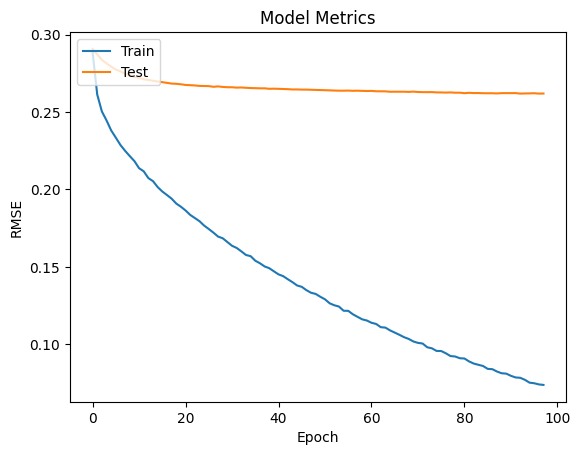

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Metrik Evaluasi menunjukkan bahwa model memiliki performa yang baik dan model konvergen pada epochs sekitar 98. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.0737 dan error pada data validasi sebesar 0.2619. Nilai tersebut dapat digunakan untuk membuat sistem rekomendasi.

- Menyimapan Model Rekomendasi & Memuat model dari format SavedModel.

In [ ]:
model.save('my_recommendation_model', save_format='tf')
loaded_model = tf.keras.models.load_model('my_recommendation_model')

## Get Movie Recommendations

- Membaca Data

In [ ]:
movie_df = preparation

- Berikut kode untuk mengambil sampel pengguna (user) secara acak dan mendapatkan film-film yang telah dikunjungi oleh pengguna tersebut. Selanjutnya, film-film yang belum dikunjungi oleh pengguna diidentifikasi menggunakan operator `bitwise ~` dan disimpan dalam variabel `movie_not_visited`. Proses ini melibatkan pemfilteran data film dengan menggunakan movieId yang tidak termasuk dalam film-film yang telah dikunjungi oleh pengguna. Setelah itu, movieId yang belum dikunjungi dikonversi menjadi list dan diubah menjadi bentuk yang sesuai untuk digunakan dalam model rekomendasi. Terakhir, sebuah array yang berisi pengguna dan film-film yang belum dikunjungi tersebut dibentuk untuk digunakan dalam proses mendapatkan rekomendasi dari model.

In [ ]:
user_id = df.userId.sample(1).iloc[0]
movie_visited_by_user = df[df.userId == user_id]

movie_not_visited = movie_df[~movie_df['movieId'].isin(movie_visited_by_user.movieId.values)]['movieId']
movie_not_visited = list(
    set(movie_not_visited)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_visited = [[movie_to_movie_encoded.get(x)] for x in movie_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_visited), movie_not_visited)
)

- Selanjutnya kita akan membuat kode untuk mendapatkan prediksi rating dari model untuk film-film yang belum dikunjungi oleh pengguna. Proses ini melibatkan penggunaan model untuk memprediksi rating untuk film-film yang belum dikunjungi, dan kemudian memilih 10 film dengan rating tertinggi sebagai rekomendasi. Hasil rekomendasi ini kemudian dicetak, termasuk film-film dengan rating tertinggi yang telah dikunjungi oleh pengguna untuk memberikan konteks lebih lanjut. Proses ini memungkinkan pengguna melihat rekomendasi film yang dapat menarik minat mereka berdasarkan model rekomendasi yang telah dibangun.







In [ ]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]

print('Menampilkan Rekomendasi untuk Pengguna (User): {}'.format(user_id))
print('===' * 9)
print('Film dengan Rating Tinggi dari Pengguna (User)')
print('----' * 8)

top_movie_user = (
    movie_visited_by_user.sort_values(
        by='rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres)

print('----' * 8)
print('10 Rekomendasi Film Teratas')
print('----' * 8)

recommended_movie = movie_df[movie_df['movieId'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

288/288 [==============================] - 1s 4ms/step
Menampilkan Rekomendasi untuk Pengguna (User): 387.0
Film dengan Rating Tinggi dari Pengguna (User)
--------------------------------
Do the Right Thing : Drama
Another Woman : Drama
Donnie Darko : Drama|Mystery|Scifi|Thriller
What's Up, Doc? : Comedy
Through a Glass Darkly : Drama
--------------------------------
10 Rekomendasi Film Teratas
--------------------------------
When We Were Kings : Documentary
Flamingo Kid, The : Comedy|Drama
Before Night Falls : Drama
Changing Lanes : Drama|Thriller
Cherish : Comedy|Drama|Thriller
Man Who Fell to Earth, The : Drama|Scifi
Talladega Nights: The Ballad of Ricky Bobby : Action|Comedy
Into the Wild : Action|Adventure|Drama
Visitor, The : Drama|Romance
Submarine : Comedy|Drama|Romance
